In [6]:
import tensorflow as tf
import sklearn as sk
from skimage.util import random_noise
import keras
import numpy as np
import os

In [7]:
def eliminateCorruptData(dir):
    for root, _, files in os.walk(dir):
        for name in files:
            path = os.path.join(root, name)
            if os.path.getsize(path) <= 0:
                os.remove(path)

def normalizeData(dataset):
    dataset = dataset.astype("float32") / 255.0
    return dataset

def readAndPreprocessData(path, val_factor):
    dataset = keras.preprocessing.image.image_dataset_from_directory(
        path,
        image_size=(28, 28),
        seed=32
    )
    raw_data = np.array([list(x[0].numpy()) for x in list(dataset.unbatch())])
    ground_truth = np.array([x[1].numpy() for x in list(dataset.unbatch())])
    val_size = int(len(raw_data) * (1 - val_factor))
    raw_data = normalizeData(raw_data)
    noise_data = random_noise(raw_data, seed=32)
    (train_set, test_set) = (raw_data[0:val_size], raw_data[val_size:len(raw_data)])
    (train_noise, test_noise) = (noise_data[0:val_size], noise_data[val_size:len(raw_data)])
    
    return (train_set, test_set), (train_noise, test_noise), (raw_data, ground_truth)
    

In [8]:
path = "dataset"
(train_set, test_set), (train_noise, test_noise), (raw_data, ground_truth) = readAndPreprocessData(path, 0.2)

Found 55207 files belonging to 18 classes.


In [17]:
_, _, _, channels = np.shape(train_set)
input_layer = keras.Input((28, 28, channels))
conv1 = keras.layers.Conv2D(32, 3, padding="same", activation="relu")(input_layer)
pool1 = keras.layers.MaxPooling2D(padding="same")(conv1)
conv2 = keras.layers.Conv2D(64, 5, padding="same", activation="relu")(pool1)
pool2 = keras.layers.MaxPooling2D(padding="same")(conv2)
conv3 = keras.layers.Conv2D(128, 7, padding="same", activation="relu")(pool2)
pool3 = keras.layers.MaxPooling2D((7, 7), padding="same")(conv3)
flat_layer = keras.layers.Flatten()(pool3)
dense_layer = keras.layers.Dense(10)(flat_layer)

encoder = keras.Model(input_layer, dense_layer, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         401536    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         0   

In [18]:
decode_layer = keras.layers.Dense((1 * 1 * 128), activation="relu")(dense_layer)
reshape_layer = keras.layers.Reshape((1, 1, 128))(decode_layer)
convt1 = keras.layers.Conv2DTranspose(128, 7, strides=7, activation="relu")(reshape_layer)
convt2 = keras.layers.Conv2DTranspose(64, 5, strides=2, padding="same", activation="relu")(convt1)
convt3 = keras.layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(convt2)
decoded = keras.layers.Conv2DTranspose(channels, 3, padding="same", activation="sigmoid")(convt3)

autoencoder = keras.Model(input_layer, decoded, name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         401536    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 128)         

In [19]:
es = tf.keras.callbacks.EarlyStopping()
autoencoder.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
autoencoder.fit(train_set, train_set, epochs=50, validation_data=(test_set, test_set), callbacks=[es])

Epoch 1/50
1381/1381 [==============================] - 292s 211ms/step - loss: 0.3359 - accuracy: 0.6857 - val_loss: 0.3182 - val_accuracy: 0.6988


In [20]:
from sklearn.manifold import TSNE

data = encoder.predict(raw_data)
reduced_features = TSNE().fit_transform(data)
np.shape(reduced_features)

(55207, 2)

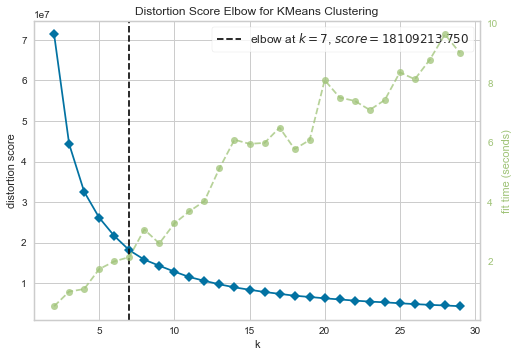

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,30), timings=True)
visualizer.fit(reduced_features)       
visualizer.show()

In [38]:
labels = KMeans(n_clusters=7).fit_predict(reduced_features)

In [39]:
from sklearn.metrics import completeness_score

with open("results/custom_data_kmeans.txt", "w") as f:
    f.write(str(completeness_score(ground_truth, labels)))

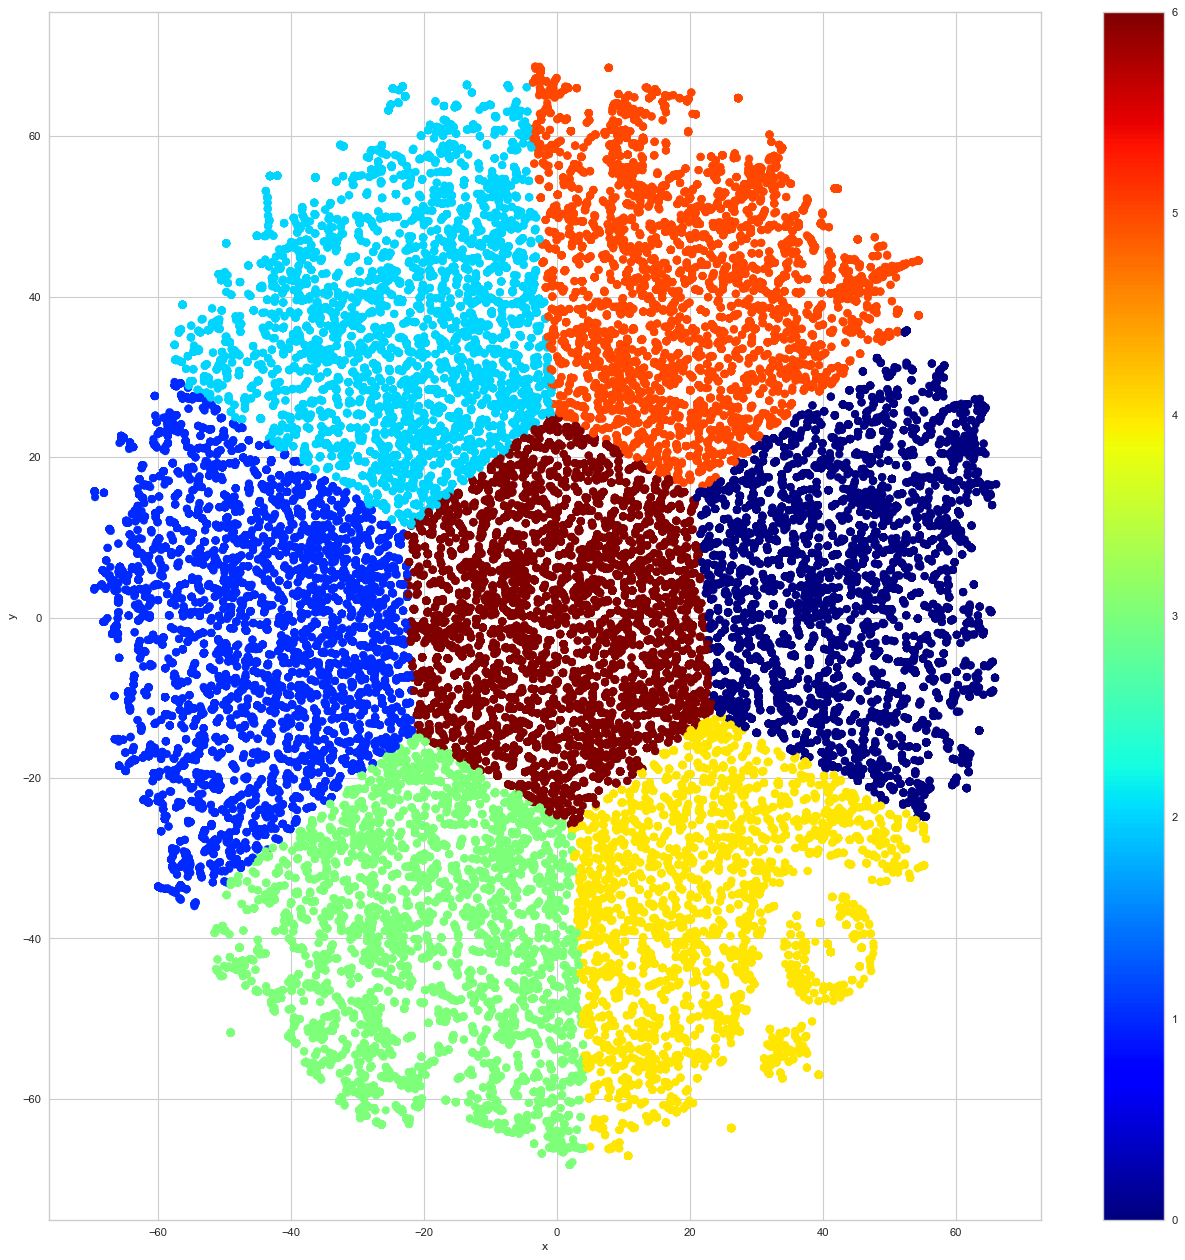

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20.0, 20.0), dpi=80)
ax = fig.add_subplot(111)
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, s=50, cmap="jet")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.colorbar(scatter)
plt.show()

In [31]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

def plotEpsDBSCAN(reduced_features):
    neigh = NearestNeighbors(n_neighbors=4)
    nbrs = neigh.fit(reduced_features)
    distances, indices = nbrs.kneighbors(reduced_features)

    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)

def visualizeDataDBSCAN(reduced_features, eps):
    labels = DBSCAN(eps=eps, min_samples=4).fit_predict(reduced_features)
    
    fig = plt.figure(figsize=(20.0, 20.0), dpi=80)
    ax = fig.add_subplot(111)
    scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, s=50, cmap="jet")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(scatter)
    plt.show()
    return labels

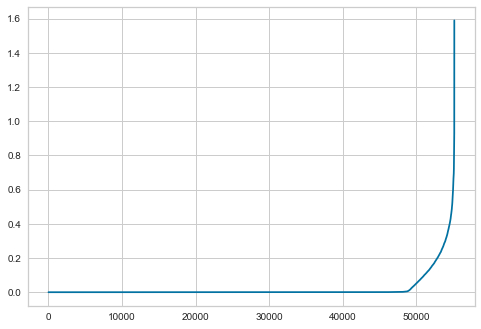

In [32]:
plotEpsDBSCAN(reduced_features)

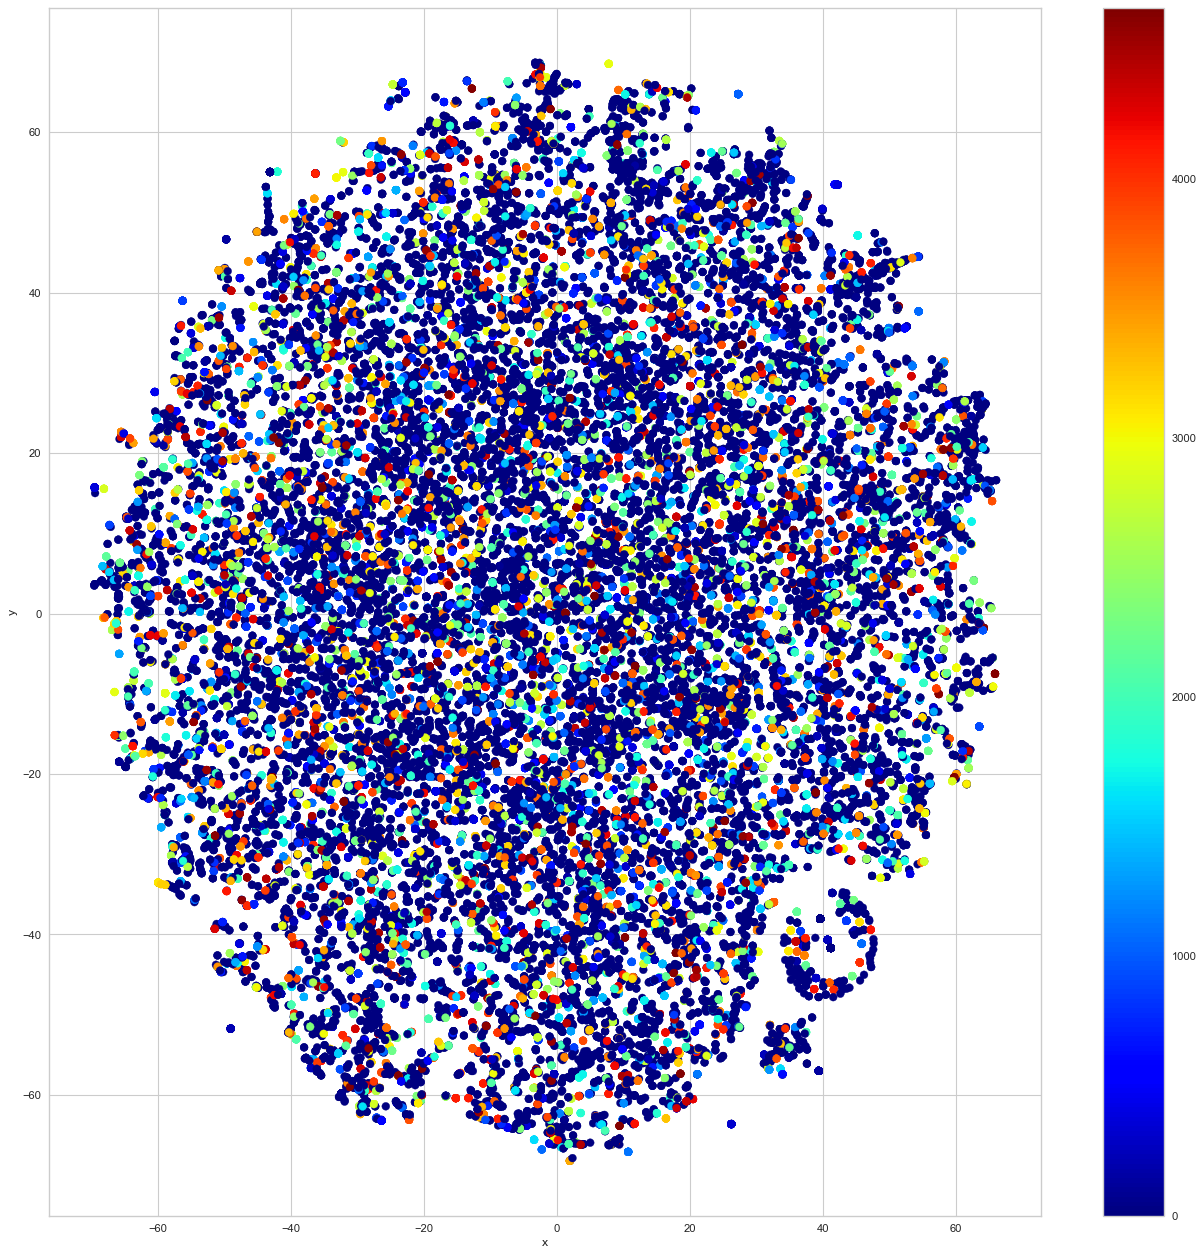

In [41]:
labels = visualizeDataDBSCAN(reduced_features, 0.01)

In [42]:
with open("results/custom_data_dbscan.txt", "w") as f:
    f.write(str(completeness_score(ground_truth, labels)))

In [47]:
print(len(np.unique(labels)))

4660


In [46]:
np.savetxt("results/ground_truth.txt", ground_truth)